# <span style="color:#e0bda8; font-size: 40px;">To Grant or Not to Grant - Pre-Processing, Feature Selection and Modelling</span>


# <span style="color:#e0bda8">0. Context</span>

The New York Workers’ Compensation Board (WCB) handles claims related to workplace injuries, a process that is often time-consuming when done manually. This project aims to develop a machine learning model to predict the "Claim Injury Type" based on historical claims data from 2020 to 2022. By automating this classification, we can help the WCB make quicker and more accurate decisions.

The project involves building and evaluating various multiclass classification models, optimizing their performance, and exploring key features that contribute to accurate predictions. Ultimately, the goal is to identify the best model that can efficiently assist in the decision-making process for new claims.


# <span style="color:#e0bda8">1. Import Packages and Libraries</span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import os
import sqlite3
from itertools import product
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LassoCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import CategoricalNB
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# <span style="color:#e0bda8">2. Reading the Data</span>

In [2]:
df = pd.read_csv("./resources/train_data.csv")
df

<ipython-input-2-ed39e2676316>:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./resources/train_data.csv")


,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,...,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,...,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,...,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,...,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593466,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
593467,2022-12-13,72.0,N,2022-12-31,N,0.00,1950.0,2022-12-31,NaN,TECHNOLOGY INSURANCE CO. INC.,...,25.0,FROM DIFFERENT LEVEL (ELEVATION),90.0,MULTIPLE PHYSICAL INJURIES ONLY,-9.0,MULTIPLE,12779,0.0,Not Work Related,3.0
593468,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
593469,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# <span style="color:#e0bda8">3. Metadata</span>
- **Accident Date** - Injury date of the claim.
- **Age at Injury** - Age of injured worker when the injury occured.
- **Alternative Dispute Resolution** - Adjudication processes external to the Board.
- **Assembly Date** - The date the claim was first assembled.
- **Attorney/Representative** - Is the claim being represented by an Attorney?
- **Average Weekly Wage** - The wage used to calculate workers' compensation, disability, or an Paid Leave wage replacement benefits.
- **Birth Year** - The reported year of birth of the injured worker.
- **C-2 Date** - Date of receipt of the Employer's Report of Work-Related Injury/Illness or equivalent (formerly Form C-2).
- **C-3 Date** - Date Form C-3 (Employee Claim Form) was received.
- **Carrier Name** - Name of primary insurance provider responsible for providing workers' compensation coverage to the injured worker's employer.
- **Carrier Type** - Type of primary insurance provider responsible for providing workers' compensation coverage.
- **Claim Identifier** - Unique identifier for each claim, assigned by WCB.
- **Count of Injury** - Name of the New York County where the injury occured.
- **COVID-19 Indicator** - Indication that the claim may be associated with COVID-19.
- **District Name** - Name of the WCB district office that oversees claims for that region or area of the state.
- **First Hearing Date** - Date the first hearing was held on a claim at a WCB hearing location. A blank date means the claim has not yet had a hearing held.
- **Gender** - The reported gender of the injured worker.
- **IME-4 Count** - Number of IME-4 forms received per claim. The IME-4 form is the "Independent Examiner's Report of Independent Medical Examination" form.
- **Industry Code** - NAICS code and descriptions are available at: https://www.naics.com/search-naics-codes-by-industry/.
- **Industry Code Description** - 2-digit NAICS industry code description used to classify businesses according to their economic activity.
- **Medical Fee Region** - Approximate region where the injured worker would receive medical service.
- **OIICS Nature of Injury Description** - The OIICS nature of injury codes & descriptions are available at: https://www.bls.gov/iif/oiics_manual_2007.pdf.
- **WCIO Cause of Injury Code** - The WCIO cause of injury codes & descriptions are  at https://www.wcio.org/Active%20PNC/WCIO_Cause_Table.pdf.
- **WCIO Cause of Injury Description** - See description of field above.
- **WCIO Nature of Injury Code** - The WCIO nature of injury are available at
 https://www.wcio.org/Active%20PNC/WCIO_Nature_Table.pdf.
- **WCIO Nature of Injury Description** - See description of field above.
- **WCIO Part Of Body Code** - The WCIO part of body codes & descriptions are available at https://www.wcio.org/Active%20PNC/WCIO_Part_Table.pdf.
- **WCIO Part Of Body Description** - See description of field above.
- **Zip Code** - The reported ZIP code of the injured worker’s home address.
- **Agreement Reached** - Binary variable: Yes if there is an agreement without the involvement of the WCB -> unknown at the start of a claim.
- **WCB Decision** - Multiclass variable: Decision of the WCB relative to the claim: “Accident” means that claim refers to workplace accident, “Occupational Disease” means illness from the workplace. -> requires WCB deliberation so it is unknown at start of claim.
- **Claim Injury Type** - Main target variable: Deliberation of the WCB relative to benefits awarded to the claim. Numbering indicates severity.

# <span style="color:#e0bda8">4. Conversions</span>

## Binary Representation Conversion
Our dataset has 4 binary variables: `Alternative Dispute Resolution`, `Attorney/Representative`, `COVID-19 INDICATOR`, `Agreement Reached`, which we will now convert to the same notation. 

In [3]:
df["Alternative Dispute Resolution"].value_counts()

Alternative Dispute Resolution
N    571412
Y      2609
U         5
Name: count, dtype: int64

In [4]:
# Convert Attorney/Representative to binary representation
df["Alternative Dispute Resolution"] = df["Alternative Dispute Resolution"].map(
    {"Y": 1, "N": 0, "U": np.nan}
)

# Verify the conversion
df["Alternative Dispute Resolution"].unique()

array([ 0., nan,  1.])

In [5]:
df["Attorney/Representative"].value_counts()

Attorney/Representative
N    392291
Y    181735
Name: count, dtype: int64

In [6]:
# Convert Attorney/Representative to binary representation
df["Attorney/Representative"] = df["Attorney/Representative"].map({"Y": 1, "N": 0})

# Verify the conversion
df["Attorney/Representative"].value_counts()

Attorney/Representative
0.0    392291
1.0    181735
Name: count, dtype: int64

In [7]:
df["COVID-19 Indicator"].value_counts()

COVID-19 Indicator
N    546505
Y     27521
Name: count, dtype: int64

In [8]:
# Convert COVID-19 Indicator to binary representation
df["COVID-19 Indicator"] = df["COVID-19 Indicator"].map({"Y": 1, "N": 0})

# Verify the conversion
df["COVID-19 Indicator"].value_counts()

COVID-19 Indicator
0.0    546505
1.0     27521
Name: count, dtype: int64

In [9]:
# No need to change
df["Agreement Reached"].value_counts()

Agreement Reached
0.0    547239
1.0     26787
Name: count, dtype: int64

## Data Type Conversion

In [10]:
# Lists of variables by type
datetime_vars = [
    "Accident Date",
    "Assembly Date",
    "C-2 Date",
    "C-3 Date",
    "First Hearing Date",
]
categorical_vars = [
    "Alternative Dispute Resolution",
    "Attorney/Representative",
    "Carrier Name",
    "Carrier Type",
    "Claim Identifier",
    "Claim Injury Type",
    "County of Injury",
    "COVID-19 Indicator",
    "District Name",
    "Gender",
    "Industry Code",
    "Industry Code Description",
    "WCIO Cause of Injury Description",
    "WCIO Nature of Injury Description",
    "WCIO Part Of Body Description",
    "Zip Code",
    "Agreement Reached",
    "WCB Decision",
    "WCIO Cause of Injury Code",
    "WCIO Nature of Injury Code",
    "WCIO Part Of Body Code",
    "OIICS Nature of Injury Description",
    "Medical Fee Region",
]
int_vars = ["Age at Injury", "Birth Year", "IME-4 Count", "Number of Dependents"]

# Changing data types
df[datetime_vars] = df[datetime_vars].apply(
    pd.to_datetime, errors="coerce"
)  # Change to datetime
df[categorical_vars] = df[categorical_vars].astype("object")  # Change to category
df[int_vars] = df[int_vars].astype(
    "Int64"
)  # Use 'Int64' with a capital I to allow NaNs

# Display the updated DataFrame dtypes
print(df.dtypes)

Accident Date                         datetime64[ns]
Age at Injury                                  Int64
Alternative Dispute Resolution                object
Assembly Date                         datetime64[ns]
Attorney/Representative                       object
Average Weekly Wage                          float64
Birth Year                                     Int64
C-2 Date                              datetime64[ns]
C-3 Date                              datetime64[ns]
Carrier Name                                  object
Carrier Type                                  object
Claim Identifier                              object
Claim Injury Type                             object
County of Injury                              object
COVID-19 Indicator                            object
District Name                                 object
First Hearing Date                    datetime64[ns]
Gender                                        object
IME-4 Count                                   

# <span style="color:#e0bda8">5. Data Preprocessing</span>

In [11]:
df_pre_processing = df.copy()

We check for missing values on each category

In [12]:
df_pre_processing.isna().sum()

Accident Date                          23134
Age at Injury                          19445
Alternative Dispute Resolution         19450
Assembly Date                              0
Attorney/Representative                19445
Average Weekly Wage                    48096
Birth Year                             48523
C-2 Date                               34005
C-3 Date                              406226
Carrier Name                           19445
Carrier Type                           19445
Claim Identifier                           0
Claim Injury Type                      19445
County of Injury                       19445
COVID-19 Indicator                     19445
District Name                          19445
First Hearing Date                    442673
Gender                                 19445
IME-4 Count                           460668
Industry Code                          29403
Industry Code Description              29403
Medical Fee Region                     19445
OIICS Natu

The column: 'OIICS Nature of Injury Description' is missing all its values, so we drop it.

In [13]:
df_pre_processing = df_pre_processing.drop("OIICS Nature of Injury Description", axis=1)

There's a lot of columns with the same number of missing values (19945) and none has less than that besides Assembly Date and Claim Identifier. Let's check if the 19945 missing values on all the remaining columns match. If they do, this means that there's no information on those patients so we should remove those rows.

In [14]:
no_district = df_pre_processing[df_pre_processing["District Name"].isna()]

In [15]:
no_district.isna().all()

Accident Date                         True
Age at Injury                         True
Alternative Dispute Resolution        True
Assembly Date                        False
Attorney/Representative               True
Average Weekly Wage                   True
Birth Year                            True
C-2 Date                              True
C-3 Date                              True
Carrier Name                          True
Carrier Type                          True
Claim Identifier                     False
Claim Injury Type                     True
County of Injury                      True
COVID-19 Indicator                    True
District Name                         True
First Hearing Date                    True
Gender                                True
IME-4 Count                           True
Industry Code                         True
Industry Code Description             True
Medical Fee Region                    True
WCIO Cause of Injury Code             True
WCIO Cause 

As the assumption was verified, the rows from the dataset were removed.

In [16]:
df_pre_processing = df_pre_processing.drop(no_district.index)

IME-4 Count has many missing values, but maybe this means they didn't count any (so should be 0). After verifying that there are no 0s in IME-4 Count, the missing values were filled with 0.

In [17]:
df_pre_processing["IME-4 Count"].unique()

<IntegerArray>
[<NA>,    4,    1,    3,    2,    6,    7,    5,   10,   12,    8,    9,   11,
   13,   14,   36,   15,   20,   19,   18,   27,   17,   16,   24,   22,   26,
   21,   23,   30,   32,   39,   25,   29,   47,   48,   34,   28,   37,   31,
   35,   33,   73]
Length: 42, dtype: Int64

In [18]:
df_pre_processing["IME-4 Count"] = df_pre_processing["IME-4 Count"].fillna(0)

WCB Decision only has "Not Work Related", so we drop it.

In [19]:
df_pre_processing["WCB Decision"].value_counts(dropna=False)

WCB Decision
Not Work Related    574026
Name: count, dtype: int64

In [20]:
df_pre_processing = df_pre_processing.drop("WCB Decision", axis=1)

Some birth years and age at injury can be calculated by using other date columns

In [21]:
df_pre_processing[
    "Age at Injury"
].value_counts().sort_index()  # there are some ages wrongfully registered as 0 (lowest value)

Age at Injury
0      5464
1         2
5         1
7         2
8         6
       ... 
112      24
113       1
114       1
115       1
117       2
Name: count, Length: 108, dtype: Int64

In [22]:
df_pre_processing[
    "Birth Year"
].value_counts().sort_index()  # there are also some birth years wrongfully registered as 0 (lowest value)

Birth Year
0       25081
1900        2
1901       30
1902       28
1903       35
        ...  
2011        6
2012        2
2013        1
2014        2
2018        2
Name: count, Length: 107, dtype: Int64

In [23]:
df_pre_processing["Calculated Birth Year"] = (
    df_pre_processing["Accident Date"].dt.year - df_pre_processing["Age at Injury"]
)

df_pre_processing["Calculated Age at Injury"] = (
    df_pre_processing["Accident Date"].dt.year - df_pre_processing["Birth Year"]
)

Case 1: The birth year calculated and the one established in the 'Birth Year' column showed significant differences for some rows. Analyzing ages_wrong (all discrepancies where 'Birth Year' was not 0), we found that these differences were due to ages being incorrectly recorded as 0 in those rows. In these cases, we replaced the age with the calculated age.

In [24]:
df_pre_processing["Birth Years Comparison"] = abs(
    df_pre_processing["Birth Year"] - df_pre_processing["Calculated Birth Year"]
)

different_birth_years = df_pre_processing[
    df_pre_processing["Birth Years Comparison"] > 1
]

ages_wrong = different_birth_years[different_birth_years["Birth Year"] > 0]

ages_indexes = ages_wrong.index

df_pre_processing.loc[ages_indexes, "Age at Injury"] = df_pre_processing.loc[
    ages_indexes, "Calculated Age at Injury"
]

In [25]:
all(ages_wrong["Age at Injury"] == 0)  # verification that all ages were 0 in that case

True

Case 2: Similar to Case 1, but this time the discrepancies in age (where it was larger than 0) occurred because all birth years were initially set to 0. We replaced the birth year in these rows with the calculated birth year.

In [26]:
df_pre_processing["Ages Comparison"] = abs(
    df_pre_processing["Age at Injury"] - df_pre_processing["Calculated Age at Injury"]
)

different_ages = df_pre_processing[df_pre_processing["Ages Comparison"] > 1]

birth_year_wrong = different_ages[different_ages["Age at Injury"] > 0]

birth_year_indexes = birth_year_wrong.index

df_pre_processing.loc[birth_year_indexes, "Birth Year"] = df_pre_processing.loc[
    birth_year_indexes, "Calculated Birth Year"
]

In [27]:
all(
    birth_year_wrong["Birth Year"] == 0
)  # verification that all birth years were 0 in that case

True

Case 3: Some birth years were missing values with the age at injury and accident date defined, so we replaced them with the calculated birth year.

In [28]:
birth_nas = df_pre_processing[df_pre_processing["Birth Year"].isna()]
age_abv_0 = birth_nas[birth_nas["Age at Injury"] > 0]
age_abv_0_indexes = age_abv_0.index
df_pre_processing.loc[age_abv_0_indexes, "Birth Year"] = df_pre_processing.loc[
    age_abv_0_indexes, "Calculated Birth Year"
]

In [29]:
any(
    age_abv_0["Age at Injury"] == 0
)  # verification that there are no 0s in age for these cases (nor missing values as we've checked before). This means that calculating Birth Year using Age at Injury is possible

False

We just wanted those columns to discover the possible values on Age at Injury and Birth Year, so now we drop them.

In [30]:
df_pre_processing = df_pre_processing.drop(
    [
        "Calculated Age at Injury",
        "Calculated Birth Year",
        "Ages Comparison",
        "Birth Years Comparison",
    ],
    axis=1,
)

In [31]:
df_pre_processing.isna().sum()

Accident Date                          3689
Age at Injury                             0
Alternative Dispute Resolution            5
Assembly Date                             0
Attorney/Representative                   0
Average Weekly Wage                   28651
Birth Year                              260
C-2 Date                              14560
C-3 Date                             386781
Carrier Name                              0
Carrier Type                              0
Claim Identifier                          0
Claim Injury Type                         0
County of Injury                          0
COVID-19 Indicator                        0
District Name                             0
First Hearing Date                   423228
Gender                                    0
IME-4 Count                               0
Industry Code                          9958
Industry Code Description              9958
Medical Fee Region                        0
WCIO Cause of Injury Code       

As 0 values in these columns are behaving as missing values, it's also important to see how many we have left.

In [32]:
len(df_pre_processing[df_pre_processing["Age at Injury"] == 0])

5371

In [33]:
len(df_pre_processing[df_pre_processing["Birth Year"] == 0])

1926

We grouped the categories WCIO Cause of Injury Code, WCIO Nature of Injury Code and WCIO Part Of Body Code by their supra code we found available.

In [34]:
# I. Burn or Scald - Heat or Cold Exposures - Contact With
burn_or_scald = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "11", "14", "84"]

# II. Caught In, Under or Between
caught_in_under_between = ["10", "12", "13", "20"]

# III. Cut, Puncture, Scrape Injured By
cut_puncture_scrape = ["15", "16", "17", "18", "19"]

# IV. Fall, Slip or Trip Injury
fall_slip_trip = ["25", "26", "27", "28", "29", "30", "31", "32", "33"]

# V. Motor Vehicle
motor_vehicle = ["40", "41", "45", "46", "47", "48", "50"]

# VI. Strain or Injury By
strain_or_injury = ["52", "53", "54", "55", "56", "57", "58", "59", "60", "61", "97"]

# VII. Striking Against or Stepping On
striking_against = ["65", "66", "67", "68", "69", "70"]

# VIII. Struck or Injured By
struck_or_injured = ["74", "75", "76", "77", "78", "79", "80", "81", "85", "86"]

# IX. Rubbed or Abraded By
rubbed_or_abraded = ["94", "95"]

# X. Miscellaneous Causes
miscellaneous = ["82", "83", "87", "88", "89", "90", "91", "93", "96", "98", "99"]


df_pre_processing["WCIO Cause of Injury Code SUPRA"] = df_pre_processing[
    "WCIO Cause of Injury Code"
].apply(
    lambda code: (
        "I. Burn or Scald - Heat or Cold Exposures - Contact With"
        if str(code).split(".")[0] in burn_or_scald
        else (
            "II. Caught In, Under or Between"
            if str(code).split(".")[0] in caught_in_under_between
            else (
                "III. Cut, Puncture, Scrape Injured By"
                if str(code).split(".")[0] in cut_puncture_scrape
                else (
                    "IV. Fall, Slip or Trip Injury"
                    if str(code).split(".")[0] in fall_slip_trip
                    else (
                        "V. Motor Vehicle"
                        if str(code).split(".")[0] in motor_vehicle
                        else (
                            "VI. Strain or Injury By"
                            if str(code).split(".")[0] in strain_or_injury
                            else (
                                "VII. Striking Against or Stepping On"
                                if str(code).split(".")[0] in striking_against
                                else (
                                    "VIII. Struck or Injured By"
                                    if str(code).split(".")[0] in struck_or_injured
                                    else (
                                        "IX. Rubbed or Abraded By"
                                        if str(code).split(".")[0] in rubbed_or_abraded
                                        else (
                                            "X. Miscellaneous Causes"
                                            if str(code).split(".")[0] in miscellaneous
                                            else np.nan
                                        )
                                    )
                                )
                            )
                        )
                    )
                )
            )
        )
    )
)

In [35]:
# Specific Injury codes (Category I)
specific_injury = [
    "1",
    "2",
    "3",
    "4",
    "7",
    "10",
    "13",
    "16",
    "19",
    "22",
    "25",
    "28",
    "30",
    "31",
    "32",
    "34",
    "36",
    "37",
    "38",
    "40",
    "41",
    "42",
    "43",
    "46",
    "47",
    "49",
    "52",
    "53",
    "54",
    "55",
    "58",
    "59",
]

# Occupational Disease or Cumulative Injury codes (Category II)
occupational_disease = [
    "60",
    "61",
    "62",
    "63",
    "64",
    "65",
    "66",
    "67",
    "68",
    "69",
    "70",
    "71",
    "72",
    "73",
    "74",
    "75",
    "76",
    "77",
    "78",
    "79",
    "80",
    "83",
]

# Multiple Injuries codes (Category III)
multiple_injuries = ["90", "91"]


df_pre_processing["WCIO Nature of Injury Code SUPRA"] = df_pre_processing[
    "WCIO Nature of Injury Code"
].apply(
    lambda code: (
        "Category I: Specific Injury"
        if str(code).split(".")[0] in specific_injury
        else (
            "Category II: Occupational Disease or Cumulative Injury"
            if str(code).split(".")[0] in occupational_disease
            else (
                "Category III: Multiple Injuries"
                if str(code).split(".")[0] in multiple_injuries
                else np.nan
            )
        )
    )
)

In [36]:
# I. Head
head = [
    "10",
    "11",
    "12",
    "13",
    "13A",
    "13B",
    "13C",
    "14",
    "14A",
    "14B",
    "14C",
    "15",
    "16",
    "17",
    "18",
    "19",
]

# II. Neck
neck = ["20", "21", "22", "23", "24", "25", "26"]

# III. Upper Extremities
upper_extremities = [
    "30",
    "31",
    "32",
    "33",
    "34",
    "35",
    "36",
    "36A",
    "36B",
    "36C",
    "36D",
    "36E",
    "36F",
    "36G",
    "36H",
    "36I",
    "36J",
    "36K",
    "36L",
    "36M",
    "36N",
    "36O",
    "36P",
    "37",
    "37A",
    "37B",
    "37C",
    "38",
    "39",
]

# IV. Trunk
trunk = [
    "40",
    "41",
    "42",
    "43",
    "44",
    "45",
    "46",
    "47",
    "48",
    "49",
    "60",
    "61",
    "62",
    "63",
]

# V. Lower Extremities
lower_extremities = [
    "50",
    "51",
    "52",
    "53",
    "54",
    "55",
    "56",
    "57",
    "57A",
    "57B",
    "57C",
    "57D",
    "57E",
    "57F",
    "57G",
    "58",
    "58A",
    "58B",
    "58C",
]

# VI. Multiple Body Parts
multiple_body_parts = ["64", "65", "66", "90", "91", "99"]


df_pre_processing["WCIO Part Of Body Code SUPRA"] = df_pre_processing[
    "WCIO Part Of Body Code"
].apply(
    lambda code: (
        "I. Head"
        if str(code).split(".")[0] in head
        else (
            "II. Neck"
            if str(code).split(".")[0] in neck
            else (
                "III. Upper Extremities"
                if str(code).split(".")[0] in upper_extremities
                else (
                    "IV. Trunk"
                    if str(code).split(".")[0] in trunk
                    else (
                        "V. Lower Extremities"
                        if str(code).split(".")[0] in lower_extremities
                        else (
                            "VI. Multiple Body Parts"
                            if str(code).split(".")[0] in multiple_body_parts
                            else np.nan
                        )
                    )
                )
            )
        )
    )
)

Now we will drop some columns that we will not need further down our analysis.

In [37]:
df_pre_processing = df_pre_processing.drop(
    [
        "C-3 Date",
        "Industry Code",
        "Industry Code Description",
        "WCIO Cause of Injury Code",
        "WCIO Cause of Injury Description",
        "WCIO Nature of Injury Code",
        "WCIO Nature of Injury Description",
        "WCIO Part Of Body Code",
        "WCIO Part Of Body Description",
        "Zip Code",
    ],
    axis=1,
)

In [38]:
df_pre_processing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 574026 entries, 0 to 593467
Data columns (total 24 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Accident Date                     570337 non-null  datetime64[ns]
 1   Age at Injury                     574026 non-null  Int64         
 2   Alternative Dispute Resolution    574021 non-null  object        
 3   Assembly Date                     574026 non-null  datetime64[ns]
 4   Attorney/Representative           574026 non-null  object        
 5   Average Weekly Wage               545375 non-null  float64       
 6   Birth Year                        573766 non-null  Int64         
 7   C-2 Date                          559466 non-null  datetime64[ns]
 8   Carrier Name                      574026 non-null  object        
 9   Carrier Type                      574026 non-null  object        
 10  Claim Identifier                  574

In [39]:
df_pre_processing.isna().sum()

Accident Date                         3689
Age at Injury                            0
Alternative Dispute Resolution           5
Assembly Date                            0
Attorney/Representative                  0
Average Weekly Wage                  28651
Birth Year                             260
C-2 Date                             14560
Carrier Name                             0
Carrier Type                             0
Claim Identifier                         0
Claim Injury Type                        0
County of Injury                         0
COVID-19 Indicator                       0
District Name                            0
First Hearing Date                  423228
Gender                                   0
IME-4 Count                              0
Medical Fee Region                       0
Agreement Reached                        0
Number of Dependents                     0
WCIO Cause of Injury Code SUPRA      15640
WCIO Nature of Injury Code SUPRA     15657
WCIO Part O

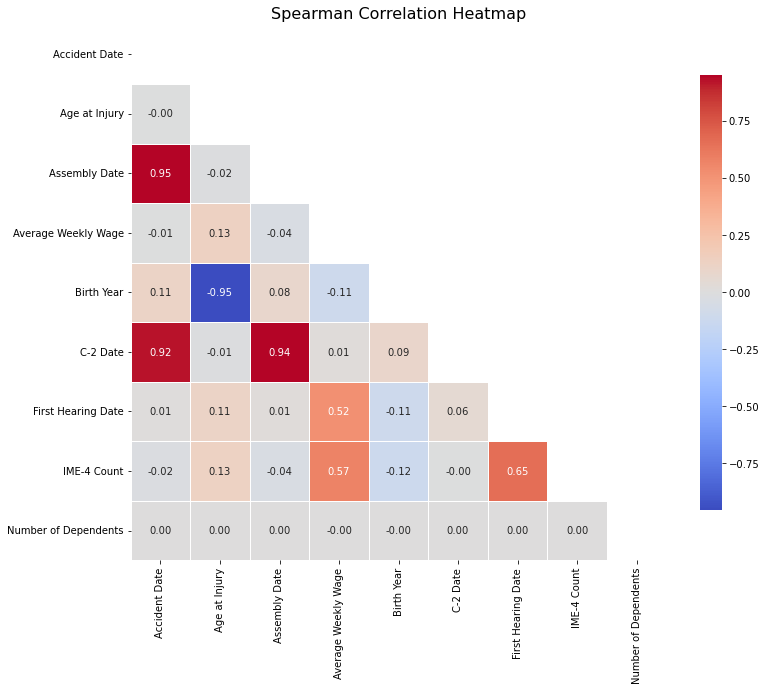

In [40]:
# Obtain the Spearman correlation matrix
cor_spearman = df_pre_processing.select_dtypes(exclude="object").corr(method="spearman")

# Create a mask for the upper triangle (if you want to hide it)
mask = np.triu(np.ones_like(cor_spearman, dtype=bool))

# Define a custom colormap (you can modify the colors as needed)
custom_cmap = sns.color_palette(
    "coolwarm", as_cmap=True
)  # Change to your preferred colormap

# Optionally, define whether to annotate or not
annot = True  # Set to True to show the correlation coefficients

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    data=cor_spearman,
    annot=annot,
    cmap=custom_cmap,
    mask=mask,
    fmt=".2f",  # Format for the annotation, use '.2f' for float
    square=True,  # Keep cells square
    linewidths=0.5,  # Add lines between cells for clarity
    cbar_kws={"shrink": 0.8},
)  # Adjust the colorbar size

# Add title
plt.title("Spearman Correlation Heatmap", fontsize=16)

# Show the heatmap
plt.show()

Now that we have inserted all values that we could assume/calculate with precision, we split the dataframe into a training set and a validation set, so that we can input all the other missing values and outliers.

In [41]:
df_pre_processing.dropna(subset=["Claim Injury Type"], inplace=True)
df_pre_processing.set_index("Claim Identifier", inplace=True)


X = df_pre_processing.copy().drop(["Claim Injury Type"], axis=1)


y = df_pre_processing["Claim Injury Type"]



X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y, shuffle=True
)

In [42]:
# Check the updated number of missing values
X_train.isna().sum()

Accident Date                         2586
Age at Injury                            0
Alternative Dispute Resolution           3
Assembly Date                            0
Attorney/Representative                  0
Average Weekly Wage                  20057
Birth Year                             189
C-2 Date                             10195
Carrier Name                             0
Carrier Type                             0
County of Injury                         0
COVID-19 Indicator                       0
District Name                            0
First Hearing Date                  296254
Gender                                   0
IME-4 Count                              0
Medical Fee Region                       0
Agreement Reached                        0
Number of Dependents                     0
WCIO Cause of Injury Code SUPRA      10956
WCIO Nature of Injury Code SUPRA     10970
WCIO Part Of Body Code SUPRA         41439
dtype: int64

In [43]:
X_train.isna().sum() / X_train.shape[0] * 100

Accident Date                        0.643575
Age at Injury                        0.000000
Alternative Dispute Resolution       0.000747
Assembly Date                        0.000000
Attorney/Representative              0.000000
Average Weekly Wage                  4.991563
Birth Year                           0.047036
C-2 Date                             2.537218
Carrier Name                         0.000000
Carrier Type                         0.000000
County of Injury                     0.000000
COVID-19 Indicator                   0.000000
District Name                        0.000000
First Hearing Date                  73.728404
Gender                               0.000000
IME-4 Count                          0.000000
Medical Fee Region                   0.000000
Agreement Reached                    0.000000
Number of Dependents                 0.000000
WCIO Cause of Injury Code SUPRA      2.726608
WCIO Nature of Injury Code SUPRA     2.730092
WCIO Part Of Body Code SUPRA      

Missing values on First Hearing Date are hearings not scheduled yet, so we equalled them to the most recent available 

In [44]:
max_date = X_train["First Hearing Date"].max()
X_train["First Hearing Date"] = X_train["First Hearing Date"].fillna(max_date)
X_val["First Hearing Date"] = X_val["First Hearing Date"].fillna(max_date)

As the percentage of missing values in "Accident Date" and "C-2 Date" are low, we replaced them with the median of each respectively.

In [45]:
median_accident_date = X_train["Accident Date"].median()
X_train["Accident Date"] = X_train["Accident Date"].fillna(median_accident_date)
X_val["Accident Date"] = X_val["Accident Date"].fillna(median_accident_date)

median_C2_date = X_train["C-2 Date"].median()
X_train["C-2 Date"] = X_train["C-2 Date"].fillna(median_C2_date)
X_val["C-2 Date"] = X_val["C-2 Date"].fillna(median_C2_date)

In [46]:
X_train.isna().sum()

Accident Date                           0
Age at Injury                           0
Alternative Dispute Resolution          3
Assembly Date                           0
Attorney/Representative                 0
Average Weekly Wage                 20057
Birth Year                            189
C-2 Date                                0
Carrier Name                            0
Carrier Type                            0
County of Injury                        0
COVID-19 Indicator                      0
District Name                           0
First Hearing Date                      0
Gender                                  0
IME-4 Count                             0
Medical Fee Region                      0
Agreement Reached                       0
Number of Dependents                    0
WCIO Cause of Injury Code SUPRA     10956
WCIO Nature of Injury Code SUPRA    10970
WCIO Part Of Body Code SUPRA        41439
dtype: int64

After we solved the cases where we could estimate the Age at Injury and Birth Year missing values more precisely, we filled the remaining ones (including zeros) with the median age and the median year, respectively 

In [47]:
median_train_age = X_train.loc[X_train["Age at Injury"] != 0, "Age at Injury"].median()
X_train["Age at Injury"] = X_train["Age at Injury"].replace(0, median_train_age)
X_val["Age at Injury"] = X_val["Age at Injury"].replace(0, median_train_age)

In [48]:
median_year = X_train.loc[X_train["Birth Year"] != 0, "Birth Year"].median()
X_train["Birth Year"] = X_train["Birth Year"].replace(0, median_year)
X_train["Birth Year"] = X_train["Birth Year"].fillna(median_year)

X_val["Birth Year"] = X_val["Birth Year"].replace(0, median_year)
X_val["Birth Year"] = X_val["Birth Year"].fillna(median_year)

In [49]:
X_train.isna().sum()

Accident Date                           0
Age at Injury                           0
Alternative Dispute Resolution          3
Assembly Date                           0
Attorney/Representative                 0
Average Weekly Wage                 20057
Birth Year                              0
C-2 Date                                0
Carrier Name                            0
Carrier Type                            0
County of Injury                        0
COVID-19 Indicator                      0
District Name                           0
First Hearing Date                      0
Gender                                  0
IME-4 Count                             0
Medical Fee Region                      0
Agreement Reached                       0
Number of Dependents                    0
WCIO Cause of Injury Code SUPRA     10956
WCIO Nature of Injury Code SUPRA    10970
WCIO Part Of Body Code SUPRA        41439
dtype: int64

We added new measures to count the days each process took to occur. 

In [50]:
X_train["Accident to C-2 Days"] = (
    X_train["C-2 Date"] - X_train["Accident Date"]
).dt.days
X_train["Accident to Assembly Days"] = (
    X_train["Assembly Date"] - X_train["Accident Date"]
).dt.days
X_train["Accident to First Hearing Days"] = (
    X_train["First Hearing Date"] - X_train["Accident Date"]
).dt.days

X_val["Accident to C-2 Days"] = (X_val["C-2 Date"] - X_val["Accident Date"]).dt.days
X_val["Accident to Assembly Days"] = (
    X_val["Assembly Date"] - X_val["Accident Date"]
).dt.days
X_val["Accident to First Hearing Days"] = (
    X_val["First Hearing Date"] - X_val["Accident Date"]
).dt.days

We replaced the wrong days (negative, meaning they put the accident date after the remaining ones which is a mistake) for each category with the median. For C-2 Date, we also filled the missing values with the median (the others don't have missing values).

In [51]:
wrong_c2_train = X_train[X_train["Accident to C-2 Days"] < 0]
c2_train_median = X_train.loc[
    X_train["Accident to C-2 Days"] > 0, "Accident to C-2 Days"
].median()
X_train.loc[wrong_c2_train.index, "Accident to C-2 Days"] = c2_train_median
X_train["Accident to C-2 Days"] = X_train["Accident to C-2 Days"].fillna(
    c2_train_median
)

wrong_c2_val = X_val[X_val["Accident to C-2 Days"] < 0]
X_val.loc[wrong_c2_val.index, "Accident to C-2 Days"] = c2_train_median
X_val["Accident to C-2 Days"] = X_val["Accident to C-2 Days"].fillna(c2_train_median)

In [52]:
wrong_assembly_train = X_train[X_train["Accident to Assembly Days"] < 0]
assembly_train_median = X_train.loc[
    X_train["Accident to Assembly Days"] > 0, "Accident to Assembly Days"
].median()
X_train.loc[wrong_assembly_train.index, "Accident to Assembly Days"] = (
    assembly_train_median
)

wrong_assembly_val = X_val[X_val["Accident to Assembly Days"] < 0]
X_val.loc[wrong_assembly_val.index, "Accident to Assembly Days"] = assembly_train_median

In [53]:
wrong_hearing_tdays = X_train[X_train["Accident to First Hearing Days"] < 0]
hearing_median = X_train.loc[
    X_train["Accident to First Hearing Days"] > 0, "Accident to First Hearing Days"
].median()
X_train.loc[wrong_hearing_tdays.index, "Accident to First Hearing Days"] = (
    hearing_median
)

wrong_hearing_vdays = X_val[X_val["Accident to First Hearing Days"] < 0]
X_val.loc[wrong_hearing_vdays.index, "Accident to First Hearing Days"] = hearing_median

In [54]:
X_train.isna().sum()

Accident Date                           0
Age at Injury                           0
Alternative Dispute Resolution          3
Assembly Date                           0
Attorney/Representative                 0
Average Weekly Wage                 20057
Birth Year                              0
C-2 Date                                0
Carrier Name                            0
Carrier Type                            0
County of Injury                        0
COVID-19 Indicator                      0
District Name                           0
First Hearing Date                      0
Gender                                  0
IME-4 Count                             0
Medical Fee Region                      0
Agreement Reached                       0
Number of Dependents                    0
WCIO Cause of Injury Code SUPRA     10956
WCIO Nature of Injury Code SUPRA    10970
WCIO Part Of Body Code SUPRA        41439
Accident to C-2 Days                    0
Accident to Assembly Days         

We decided to convert Alternative Dispute Resolution and Gender into binary variables. 

In [55]:
X_train["Alternative Dispute Resolution"].value_counts(dropna=False)

Alternative Dispute Resolution
0.0    399988
1.0      1827
NaN         3
Name: count, dtype: int64

In [56]:
X_train["Gender"].value_counts(dropna=False)

Gender
M    234746
F    163678
U      3360
X        34
Name: count, dtype: int64

For Alternative Dispute Resolution, we decided to fill the missing values with the X_train mode (0)
For Gender, we decided to create a new variable called Male and grouped F, U and X into the value 0 (not Male), and M into the value 1 given the fact it is the X_train mode.

In [57]:
X_train["Alternative Dispute Resolution"] = X_train[
    "Alternative Dispute Resolution"
].fillna(0)
X_val["Alternative Dispute Resolution"] = X_val[
    "Alternative Dispute Resolution"
].fillna(0)

X_train["Male"] = np.select(
    [
        X_train["Gender"] == "M",
        X_train["Gender"] == "F",
        X_train["Gender"] == "X",
        X_train["Gender"] == "U",
    ],
    [1, 0, 0, 0],
)

X_val["Male"] = np.select(
    [
        X_val["Gender"] == "M",
        X_val["Gender"] == "F",
        X_val["Gender"] == "X",
        X_val["Gender"] == "U",
    ],
    [1, 0, 0, 0],
)

We replace the missing values in the SUPRA codes with the mode 

In [58]:
cause_mode = X_train["WCIO Cause of Injury Code SUPRA"].mode().iloc[0]
nature_mode = X_train["WCIO Nature of Injury Code SUPRA"].mode().iloc[0]
body_mode = X_train["WCIO Part Of Body Code SUPRA"].mode().iloc[0]

In [59]:
X_train["WCIO Cause of Injury Code SUPRA"] = X_train[
    "WCIO Cause of Injury Code SUPRA"
].fillna(cause_mode)
X_train["WCIO Nature of Injury Code SUPRA"] = X_train[
    "WCIO Nature of Injury Code SUPRA"
].fillna(nature_mode)
X_train["WCIO Part Of Body Code SUPRA"] = X_train[
    "WCIO Part Of Body Code SUPRA"
].fillna(body_mode)

In [60]:
X_val["WCIO Cause of Injury Code SUPRA"] = X_val[
    "WCIO Cause of Injury Code SUPRA"
].fillna(cause_mode)
X_val["WCIO Nature of Injury Code SUPRA"] = X_val[
    "WCIO Nature of Injury Code SUPRA"
].fillna(nature_mode)
X_val["WCIO Part Of Body Code SUPRA"] = X_val["WCIO Part Of Body Code SUPRA"].fillna(
    body_mode
)

We now drop the columns with the remaining dates because they can't be further analyzed and Gender because we replaced it with Male.

In [61]:
to_drop = ["Accident Date", "Assembly Date", "C-2 Date", "First Hearing Date", "Gender"]

X_train = X_train.drop(to_drop, axis=1)
X_val = X_val.drop(to_drop, axis=1)

In [62]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401818 entries, 5728830 to 5674763
Data columns (total 21 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Age at Injury                     401818 non-null  Int64  
 1   Alternative Dispute Resolution    401818 non-null  float64
 2   Attorney/Representative           401818 non-null  object 
 3   Average Weekly Wage               381761 non-null  float64
 4   Birth Year                        401818 non-null  Int64  
 5   Carrier Name                      401818 non-null  object 
 6   Carrier Type                      401818 non-null  object 
 7   County of Injury                  401818 non-null  object 
 8   COVID-19 Indicator                401818 non-null  object 
 9   District Name                     401818 non-null  object 
 10  IME-4 Count                       401818 non-null  Int64  
 11  Medical Fee Region                401818 non-null 

In [63]:
# X_train = X_train.set_index("Claim Identifier")
# X_val = X_val.set_index("Claim Identifier")

## Categorical and Numerical Variables

In [64]:
numerical_cols = [
    "Age at Injury",
    "Average Weekly Wage",
    "Birth Year",
    "IME-4 Count",
    "Number of Dependents",
    "Accident to C-2 Days",
    "Accident to Assembly Days",
    "Accident to First Hearing Days",
]
X_train_numeric = X_train[numerical_cols]
X_val_numeric = X_val[numerical_cols]

categorical_cols = [
    "Alternative Dispute Resolution",
    "Attorney/Representative",
    "Carrier Name",
    "Carrier Type",
    "County of Injury",
    "COVID-19 Indicator",
    "District Name",
    "Medical Fee Region",
    "Agreement Reached",
    "WCIO Cause of Injury Code SUPRA",
    "WCIO Nature of Injury Code SUPRA",
    "WCIO Part Of Body Code SUPRA",
    "Male",
]
X_train_categorical = X_train[categorical_cols]
X_val_categorical = X_val[categorical_cols]

In [65]:
X_train_numeric.isna().sum()

Age at Injury                         0
Average Weekly Wage               20057
Birth Year                            0
IME-4 Count                           0
Number of Dependents                  0
Accident to C-2 Days                  0
Accident to Assembly Days             0
Accident to First Hearing Days        0
dtype: int64

In [66]:
X_train_numeric.loc[:, "Average Weekly Wage"] = X_train_numeric[
    "Average Weekly Wage"
].replace(0, np.nan)
X_val_numeric.loc[:, "Average Weekly Wage"] = X_val_numeric[
    "Average Weekly Wage"
].replace(0, np.nan)

## Scaling

In [67]:
minmax = MinMaxScaler()
X_train_minmax = minmax.fit_transform(X_train_numeric)
X_val_minmax = minmax.transform(X_val_numeric)

# standard = StandardScaler()
# X_train_standard = standard.fit_transform(X_train_numeric)
# X_val_standard = standard.transform(X_val_numeric)

# robust = RobustScaler()
# X_train_robust = robust.fit_transform(X_train_numeric)
# X_val_robust = robust.transform(X_val_numeric)

In [68]:
X_train_minmax = pd.DataFrame(
    X_train_minmax, columns=X_train_numeric.columns
).set_index(X_train_numeric.index)

X_val_minmax = pd.DataFrame(X_val_minmax, columns=X_val_numeric.columns).set_index(
    X_val_numeric.index
)

## Imputing Wage with KNN

In [87]:
wage_mean = X_train["Average Weekly Wage"].mean()
wage_mean

489.0248835004101

In [88]:
X_train["Average Weekly Wage"] = X_train["Average Weekly Wage"].fillna(wage_mean)
X_val["Average Weekly Wage"] = X_val["Average Weekly Wage"].fillna(wage_mean)

In [71]:
#X_train_minmax_knn_imput = X_train_minmax[["Average Weekly Wage", "IME-4 Count"]]
#X_val_minmax_knn_imput = X_val_minmax[["Average Weekly Wage", "IME-4 Count"]]

In [72]:
#imputer = KNNImputer(n_neighbors=3)
#X_train_minmax_knn_impput = imputer.fit_transform(X_train_minmax_knn_imput)
#X_val_minmax_knn_impput = imputer.transform(X_val_minmax_knn_imput)

In [73]:
#X_train_minmax["Average Weekly Wage"] = X_train_minmax_knn_impput[:, 0]
#X_val_minmax["Average Weekly Wage"] = X_val_minmax_knn_impput[:, 0]

In [74]:
#X_train = minmax.inverse_transform(X_train_minmax)
#X_val = minmax.inverse_transform(X_val_minmax)

In [75]:
#X_train = pd.DataFrame(X_train, columns=X_train_minmax.columns).set_index(
#    X_train_minmax.index
#)

#X_val = pd.DataFrame(X_val, columns=X_val_minmax.columns).set_index(X_val_minmax.index)

In [76]:
#X_train.to_csv("./processed datasets/X_train.csv")
#X_train.head()

In [77]:
#X_val.to_csv("./processed datasets/X_val.csv")
#X_val.head()

In [78]:
#X_train_categorical.to_csv("./processed datasets/X_train_categorical.csv")
#X_train_categorical.head()

In [79]:
#X_val_categorical.to_csv("./processed datasets/X_val_categorical.csv")
#X_val_categorical.head()

In [80]:
#y_train.to_csv("./processed datasets/y_train.csv")
#y_val.to_csv("./processed datasets/y_val.csv")

In [81]:
#X_train = pd.read_csv("./processed datasets/X_train.csv")
#X_train.set_index("Claim Identifier", inplace=True)


#X_val = pd.read_csv("./processed datasets/X_val.csv")
#X_val.set_index("Claim Identifier", inplace=True)


#X_train_categorical = pd.read_csv("./processed datasets/X_train_categorical.csv")
#X_train_categorical.set_index("Claim Identifier", inplace=True)

#X_val_categorical = pd.read_csv("./processed datasets/X_val_categorical.csv")
#X_val_categorical.set_index("Claim Identifier", inplace=True)

#y_train = pd.read_csv("./processed datasets/y_train.csv")
#y_train.set_index("Claim Identifier", inplace=True)
#y_val = pd.read_csv("./processed datasets/y_val.csv")
#y_val.set_index("Claim Identifier", inplace=True)

# <span style="color:#e0bda8">6. Feature Selection</span>

## Filter Methods

### Univariate Methods

In [89]:
X_train_minmax.var()

Age at Injury                     0.013219
Average Weekly Wage               0.000011
Birth Year                        0.013722
IME-4 Count                       0.000692
Number of Dependents              0.111285
Accident to C-2 Days              0.000658
Accident to Assembly Days         0.000784
Accident to First Hearing Days    0.001091
dtype: float64

### Correlation Indices

Since we have a categorical target, measuring correlations against is ill-advised (we could however use other correlation indices for this such as Point Bi-serial correlation or PhiK). Thus we will limit ourselves to using the Spearman correlation between features.

In [90]:
cor_spearman = X_train_minmax.corr(method="spearman").round(2)

mask_annot = np.absolute(cor_spearman.values) >= 0.5
annot = np.where(mask_annot, cor_spearman.values, np.full(cor_spearman.shape, ""))
annot = annot.astype(str)  # Convert to string for annotation
mask = np.triu(np.ones_like(cor_spearman, dtype=bool))

# Define the custom colors
light_color = "#e0bda8"  # Light shade
dark_color = "#c48c78"  # Darker shade
neutral_color = "#ffffff"  # Color for neutral values

# Create a custom colormap with three colors (for diverging effect)
custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap", [dark_color, neutral_color, light_color]
)

cor_spearman

,Age at Injury,Average Weekly Wage,Birth Year,IME-4 Count,Number of Dependents,Accident to C-2 Days,Accident to Assembly Days,Accident to First Hearing Days
Age at Injury,1.00,0.14,-0.99,0.13,0.0,0.05,0.05,-0.07
Average Weekly Wage,0.14,1.00,-0.14,0.05,-0.0,0.04,-0.00,0.01
Birth Year,-0.99,-0.14,1.00,-0.12,-0.0,-0.07,-0.08,0.02
IME-4 Count,0.13,0.05,-0.12,1.00,0.0,0.08,0.04,-0.47
Number of Dependents,0.00,-0.00,-0.00,0.00,1.0,0.00,0.00,-0.00
Accident to C-2 Days,0.05,0.04,-0.07,0.08,0.0,1.00,0.96,-0.02
Accident to Assembly Days,0.05,-0.00,-0.08,0.04,0.0,0.96,1.00,0.01
Accident to First Hearing Days,-0.07,0.01,0.02,-0.47,-0.0,-0.02,0.01,1.00


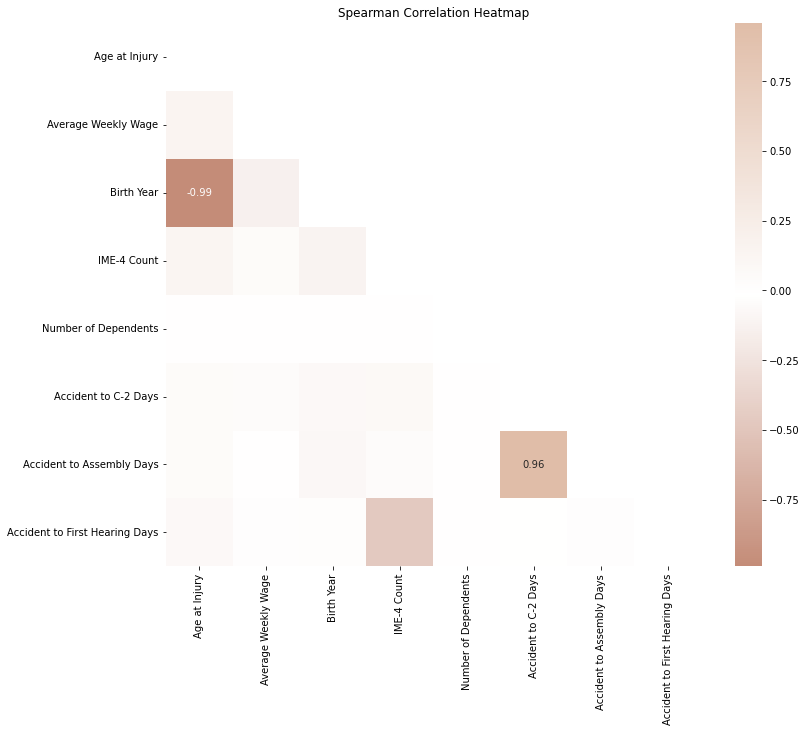

In [91]:
# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    data=cor_spearman, annot=annot, cmap=custom_cmap, mask=mask, fmt="s"
)  # fmt='s' for string
plt.title("Spearman Correlation Heatmap")
plt.show()

We can conclude that:
- We need to use other feature selection techniques to get more insights.
- There are three pairs of variables highly correlated, namely:
    - Average Weekly Wage vs Attorney/Representative (-0.99) <br>
    - Accident to Assembly Days vs Accident to C-2 Days (0.96) <br>

### Chi-Square for categorical data

In [94]:
dfObserved = X_train_categorical.copy()

# Add the target column to X_train_categorical
dfObserved["target"] = y_train

# Now X_train_categorical contains the original columns plus the target column
#dfObserved.set_index("Claim Identifier", inplace=True)

In [93]:
def TestIndependence2(var, alpha=0.05):
    # Create a contingency table for the variable against the "target" column
    contingency_table = pd.crosstab(dfObserved[var], dfObserved["target"])

    # Perform chi-square test
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table.values)

    # Create a DataFrame for expected counts
    dfExpected = pd.DataFrame(
        expected, columns=contingency_table.columns, index=contingency_table.index
    )

    # Check the p-value and print results
    if p >= alpha:
        result = f"{var} is NOT an important predictor. (Discard {var} from model)"
        print(result)
    else:
        result = f"{var} is an important predictor. (Keep {var} in model)"

    print(result)


# Loop through each column in dfObserved (excluding 'target')
for var in dfObserved.columns:
    if var != "target":
        TestIndependence2(var)

Alternative Dispute Resolution is an important predictor. (Keep Alternative Dispute Resolution in model)
Attorney/Representative is an important predictor. (Keep Attorney/Representative in model)
Carrier Name is an important predictor. (Keep Carrier Name in model)
Carrier Type is an important predictor. (Keep Carrier Type in model)
County of Injury is an important predictor. (Keep County of Injury in model)
COVID-19 Indicator is an important predictor. (Keep COVID-19 Indicator in model)
District Name is an important predictor. (Keep District Name in model)
Medical Fee Region is an important predictor. (Keep Medical Fee Region in model)
Agreement Reached is an important predictor. (Keep Agreement Reached in model)
WCIO Cause of Injury Code SUPRA is an important predictor. (Keep WCIO Cause of Injury Code SUPRA in model)
WCIO Nature of Injury Code SUPRA is an important predictor. (Keep WCIO Nature of Injury Code SUPRA in model)
WCIO Part Of Body Code SUPRA is an important predictor. (Keep

## Cramér’s V

### alpha = 0.10

In [95]:
# Updated function to calculate Cramér's V
def cramers_v(x, y):
    # Create a contingency table
    contingency_table = pd.crosstab(x, y)
    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    # Calculate Cramér's V
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))


# Function to assess importance using Cramér's V
def TestCramersV(var, alpha=0.10):
    # Calculate Cramér's V for the variable against the target
    cramers_v_score = cramers_v(dfObserved[var], dfObserved["target"])

    # Interpret the score
    if cramers_v_score < alpha:
        result = f"{var} is NOT an important predictor (Cramér's V = {cramers_v_score:.4f}). (Discard {var} from model)"
    else:
        result = f"{var} is an important predictor (Cramér's V = {cramers_v_score:.4f}). (Keep {var} in model)"

    print(result)


# Loop through each column in dfObserved (excluding the 'target' column)
for var in dfObserved.columns:
    if var != "target":
        print(f"Testing Cramér's V for {var}...")
        TestCramersV(var)

Testing Cramér's V for Alternative Dispute Resolution...
Alternative Dispute Resolution is NOT an important predictor (Cramér's V = 0.0657). (Discard Alternative Dispute Resolution from model)
Testing Cramér's V for Attorney/Representative...
Attorney/Representative is an important predictor (Cramér's V = 0.6120). (Keep Attorney/Representative in model)
Testing Cramér's V for Carrier Name...
Carrier Name is an important predictor (Cramér's V = 0.1771). (Keep Carrier Name in model)
Testing Cramér's V for Carrier Type...
Carrier Type is NOT an important predictor (Cramér's V = 0.0739). (Discard Carrier Type from model)
Testing Cramér's V for County of Injury...
County of Injury is NOT an important predictor (Cramér's V = 0.0524). (Discard County of Injury from model)
Testing Cramér's V for COVID-19 Indicator...
COVID-19 Indicator is an important predictor (Cramér's V = 0.1000). (Keep COVID-19 Indicator in model)
Testing Cramér's V for District Name...
District Name is NOT an important pr

### alpha = 0.05

In [96]:
# Updated function to calculate Cramér's V
def cramers_v(x, y):
    # Create a contingency table
    contingency_table = pd.crosstab(x, y)
    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    # Calculate Cramér's V
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))


# Function to assess importance using Cramér's V
def TestCramersV(var, alpha=0.05):
    # Calculate Cramér's V for the variable against the target
    cramers_v_score = cramers_v(dfObserved[var], dfObserved["target"])

    # Interpret the score
    if cramers_v_score < alpha:
        result = f"{var} is NOT an important predictor (Cramér's V = {cramers_v_score:.4f}). (Discard {var} from model)"
    else:
        result = f"{var} is an important predictor (Cramér's V = {cramers_v_score:.4f}). (Keep {var} in model)"

    print(result)


# Loop through each column in dfObserved (excluding the 'target' column)
for var in dfObserved.columns:
    if var != "target":
        print(f"Testing Cramér's V for {var}...")
        TestCramersV(var)

Testing Cramér's V for Alternative Dispute Resolution...
Alternative Dispute Resolution is an important predictor (Cramér's V = 0.0657). (Keep Alternative Dispute Resolution in model)
Testing Cramér's V for Attorney/Representative...
Attorney/Representative is an important predictor (Cramér's V = 0.6120). (Keep Attorney/Representative in model)
Testing Cramér's V for Carrier Name...
Carrier Name is an important predictor (Cramér's V = 0.1771). (Keep Carrier Name in model)
Testing Cramér's V for Carrier Type...
Carrier Type is an important predictor (Cramér's V = 0.0739). (Keep Carrier Type in model)
Testing Cramér's V for County of Injury...
County of Injury is an important predictor (Cramér's V = 0.0524). (Keep County of Injury in model)
Testing Cramér's V for COVID-19 Indicator...
COVID-19 Indicator is an important predictor (Cramér's V = 0.1000). (Keep COVID-19 Indicator in model)
Testing Cramér's V for District Name...
District Name is NOT an important predictor (Cramér's V = 0.042

In [97]:
# Function to calculate Cramér's V
def cramers_v(x, y):
    # Create a contingency table
    contingency_table = pd.crosstab(x, y)
    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    # Calculate Cramér's V
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))


# Initialize an empty dictionary to store Cramér's V scores
cramers_v_matrix = {}

# Loop through each column in dfObserved (excluding the 'target' column)
for var in dfObserved.columns:
    if var != "target":
        cramers_v_score = cramers_v(dfObserved[var], dfObserved["target"])
        cramers_v_matrix[var] = cramers_v_score  # Store the score in dictionary

# Convert dictionary to DataFrame for a matrix format
cramers_v_df = pd.DataFrame(cramers_v_matrix, index=["Cramér's V with Target"]).T

# Print the resulting Cramér's V matrix
print("Cramér's V Matrix (Feature vs. Target):")
print(cramers_v_df)

Cramér's V Matrix (Feature vs. Target):
                                  Cramér's V with Target
Alternative Dispute Resolution                  0.065749
Attorney/Representative                         0.612004
Carrier Name                                    0.177131
Carrier Type                                    0.073853
County of Injury                                0.052389
COVID-19 Indicator                              0.100009
District Name                                   0.042163
Medical Fee Region                              0.038865
Agreement Reached                               0.363008
WCIO Cause of Injury Code SUPRA                 0.104948
WCIO Nature of Injury Code SUPRA                0.058865
WCIO Part Of Body Code SUPRA                    0.107689
Male                                            0.095109


In [98]:
# Function to calculate Cramér's V
def cramers_v(x, y):
    # Create a contingency table
    contingency_table = pd.crosstab(x, y)
    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    # Calculate Cramér's V
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))


# Initialize an empty DataFrame for storing the Cramér's V matrix
features = dfObserved.columns
cramers_v_matrix = pd.DataFrame(
    np.zeros((len(features), len(features))), index=features, columns=features
)

# Calculate Cramér's V for each pair of features
for var1 in features:
    for var2 in features:
        cramers_v_matrix.loc[var1, var2] = cramers_v(dfObserved[var1], dfObserved[var2])

# Print the Cramér's V matrix
# print("Cramér's V Matrix (All Feature Pairs):")
# print(cramers_v_matrix)

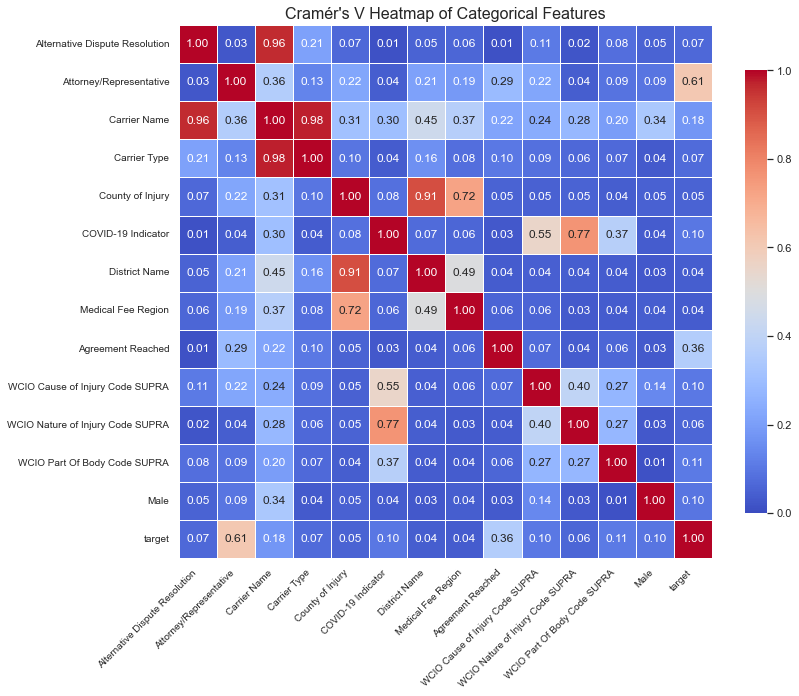

In [99]:
# Set plot size and style
plt.figure(figsize=(12, 10))
sns.set(style="white")

# Create a heatmap for the Cramér's V matrix
sns.heatmap(
    cramers_v_matrix,
    annot=True,
    cmap="coolwarm",
    vmin=0,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    fmt=".2f",
)

# Set titles and labels
plt.title("Cramér's V Heatmap of Categorical Features", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Show the heatmap
plt.tight_layout()
plt.show()

Alternativa Dispute Resolution vs Carrier Name (0.96)
Carrier Name vs Carrier Type (0.98)
County of Injury vs District Name (0.91)

WCIO Nature of Injury Code SUPRA vs COVID-19 Indicator (0.77)
Medical Fee Region vs County of Injury (0.72)


remove
- Carrier Name - highly correlated with 2 variables
- County of Injury - highly correlated with 2 variables

remove 5%
- District Name
- Medical Fee Region

remove 10%
- Alternative Dispute Resolution
- Carrier Type
- County of Injury
- District Name
- Medical Fee Region
- WCIO Nature of Injury Code SUPRA
- Male

## Wrapper Methods

### RFE (Logistic Regression)

In [204]:
# no of features
nof_list = np.arange(1, 8)
high_score = 0
# Variable to store the optimum features
nof = 0
train_score_list = []
val_score_list = []

for n in range(len(nof_list)):
    model = LogisticRegression(max_iter=1000)

    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_minmax, y_train.values.ravel())
    X_val_rfe = rfe.transform(X_val_minmax)
    model.fit(X_train_rfe, y_train.values.ravel())

    # storing results on training data
    y_train_pred = model.predict(X_train_rfe)
    train_score = f1_score(y_train, y_train_pred, average="macro")
    train_score_list.append(train_score)

    # storing results on training data
    y_val_pred = model.predict(X_val_rfe)
    val_score = f1_score(y_val, y_val_pred, average="macro")
    val_score_list.append(val_score)

    # check best score
    if val_score >= high_score:
        high_score = val_score
        nof = nof_list[n]
        # adding mention of variables to keep
        features_to_select = pd.Series(rfe.support_, index=X_train_minmax.columns)

print("Optimum number of features: %d" % nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")

Optimum number of features: 5
Score with 5 features: 0.161388
Features to select: 
Age at Injury                     False
Average Weekly Wage               False
Birth Year                         True
IME-4 Count                        True
Number of Dependents              False
Accident to C-2 Days               True
Accident to Assembly Days          True
Accident to First Hearing Days     True
dtype: bool


### RFECV (RFE with cross validation) with Logistic Regression

In [205]:
model = LogisticRegression(max_iter=1000)

# Set up the cross-validation strategy
cv = StratifiedKFold(n_splits=10)  # 10-fold cross-validation

# Create the RFECV object
rfecv = RFECV(estimator=model, step=1, cv=cv, scoring="f1_macro", n_jobs=-1)

# Fit the RFECV model to the training data
X_rfe = rfecv.fit_transform(X_train_minmax, y_train.values.ravel())

# Print the number of features selected
print("Optimal number of features: %d" % rfecv.n_features_)

# Print the selected features
print("Selected features: %s" % rfecv.support_)

selected_features = pd.Series(rfecv.support_, index=X_train_minmax.columns)

selected_features

Optimal number of features: 5
Selected features: [False False  True  True False  True  True  True]


Age at Injury                     False
Average Weekly Wage               False
Birth Year                         True
IME-4 Count                        True
Number of Dependents              False
Accident to C-2 Days               True
Accident to Assembly Days          True
Accident to First Hearing Days     True
dtype: bool

## Embedded Methods

### Lasso Regression

In [206]:
# Encoding y values

# Assuming y_train and y_val are your target labels
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(
    y_train.values.ravel()
)  # Fit and transform on training data

In [207]:
def plot_importance(coef, name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8, 10))
    imp_coef.plot(kind="barh", color="#e0bda8")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [208]:
reg = LassoCV()

In [209]:
reg.fit(X_train_minmax, y_train_encoded)

LassoCV()

In [210]:
coef = pd.Series(reg.coef_, index=X_train_minmax.columns)
coef

Age at Injury                     -4.749607
Average Weekly Wage               -1.791745
Birth Year                        -5.217547
IME-4 Count                       14.048034
Number of Dependents              -0.004821
Accident to C-2 Days              -1.128574
Accident to Assembly Days         11.925741
Accident to First Hearing Days   -13.929907
dtype: float64

In [211]:
print(
    "Lasso picked "
    + str(sum(coef != 0))
    + " variables and eliminated the other "
    + str(sum(coef == 0))
    + " variables"
)

Lasso picked 8 variables and eliminated the other 0 variables


In [212]:
coef.sort_values()

Accident to First Hearing Days   -13.929907
Birth Year                        -5.217547
Age at Injury                     -4.749607
Average Weekly Wage               -1.791745
Accident to C-2 Days              -1.128574
Number of Dependents              -0.004821
Accident to Assembly Days         11.925741
IME-4 Count                       14.048034
dtype: float64

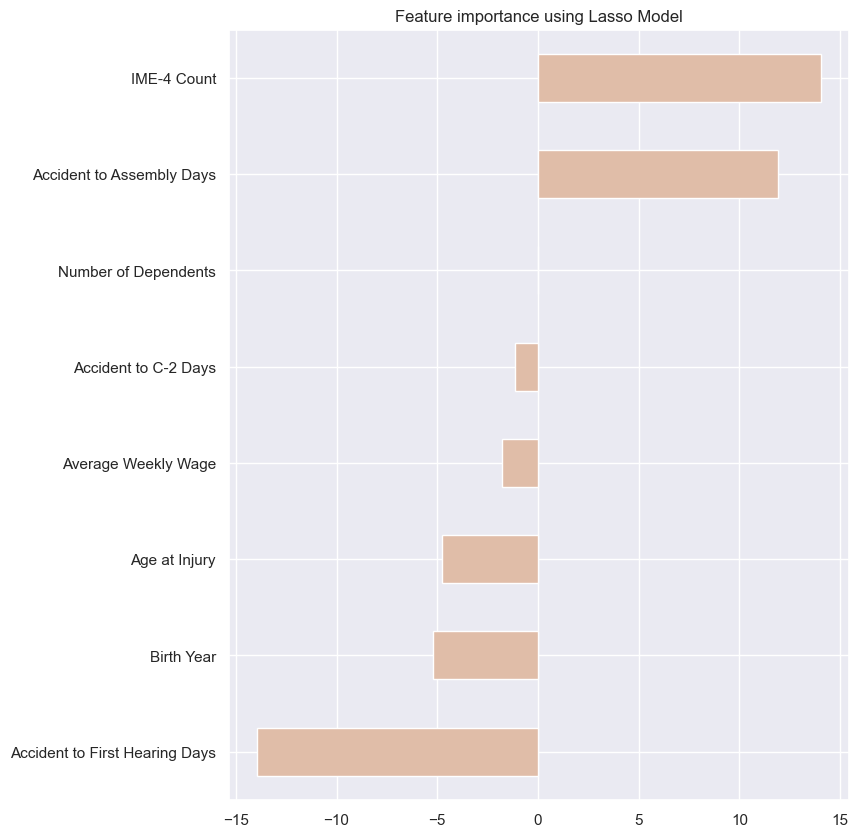

In [213]:
plot_importance(coef, "Lasso")

## Final Insights

<hr>

### Numerical Data

| Predictor | Spearman | RFE LR | RFECV LR | Lasso | What to do? (One possible way to "solve") |
| --- | --- | --- | --- |--- |---|
| Age at Injury | NO | NO | NO | YES | - |
| Average Weekly Wage | - | NO | NO | NO | - |
| Birth Year | - | YES | YES | YES | Keep |
| IME-4 Count | - | YES | YES | YES | Keep |
| Number of Dependents | - | NO | NO | NO | - |
| Accident to C-2 Days  | NO | YES | YES | NO | - |
| Accident to Assembly Days | - | YES | YES | YES | Keep |
| Accident to First Hearing Days  | - | YES | YES | YES | Keep |


### Categorical Data

| Predictor | Chi-Square | Cramér's V | 
| --- | --- | --- | 
| Alternative Dispute Resolution | - | - | 
| Attorney/Representative | - | - | 
| Carrier Name | - | - | 
| Carrier Type | - | - | 
| County of Injury | - | - | 
| COVID-19 Indicator | - | - | 
| District Name | - | - | 
| Medical Fee Region | - | - | 
| Agreement Reached | - | - | 
| WCIO Cause of Injury Code SUPRA | - | - | 
| WCIO Nature of Injury Code SUPRA | - | - | 
| WCIO Part Of Body Code SUPRA | - | - | 
| Male | - | - | 

# <span style="color:#e0bda8">7. Modelling and Assessment</span>

In [172]:
X_train_categorical_labelencoded = X_train_categorical.copy()
X_val_categorical_labelencoded = X_val_categorical.copy()
le = LabelEncoder()
for var in X_train_categorical.select_dtypes(include=["object"]):
    X_train_categorical_labelencoded[var] = le.fit_transform(X_train_categorical[var])
    X_val_categorical_labelencoded[var] = le.fit_transform(X_val_categorical[var])

In [173]:
X_train = pd.concat((X_train, X_train_categorical_labelencoded), axis=1)
X_val = pd.concat((X_val, X_val_categorical_labelencoded), axis=1)

In [ ]:
# minmax = MinMaxScaler()
# X_train_scaled = minmax.fit_transform(X_train)
# X_val_scaled = minmax.transform(X_val)

In [ ]:
# X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(
#     X_train.index
# )

# X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns).set_index(X_val.index)

In [ ]:
# X_train_scaled = X_train_scaled.drop(
#     [
#         "Age at Injury",
#         "Average Weekly Wage",
#         "Number of Dependents",
#         "Accident to C-2 Days",
#     ],
#     axis=1,
# )


# X_val_scaled = X_val_scaled.drop(
#     [
#         "Age at Injury",
#         "Average Weekly Wage",
#         "Number of Dependents",
#         "Accident to C-2 Days",
#     ],
#     axis=1,
# )

In [17]:
def select_best_models(X_train, X_val, y_train, y_val, model):
    # Train the model on the training set
    model.fit(X_train, y_train)

    # Make predictions on both training and validation sets
    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)

    # Calculate the F1 score with macro averaging for both sets
    avg_train = round(f1_score(y_train, predictions_train, average="macro"), 3)
    avg_val = round(f1_score(y_val, predictions_val, average="macro"), 3)

    return (
        avg_train,
        avg_val,
    )


def show_results(models, X_train, X_val, y_train, y_val):
    df = pd.DataFrame(
        columns=["Train", "Validation", "Diff"], index=list(models.keys())
    )
    count = 0
    for label, model in models.items():
        avg_train, avg_val = select_best_models(X_train, X_val, y_train, y_val, model)

        # Store the results in the DataFrame
        df.iloc[count] = (
            str(avg_train),
            str(avg_val),
            abs(avg_train - avg_val),
        )
        count += 1
    return df

In [18]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "KNN": KNeighborsClassifier(),
    "DT": DecisionTreeClassifier(),
    "NN": MLPClassifier(max_iter=10000, random_state=99),
    "SVC": SVC(max_iter=10000),
    "Categorical NB": CategoricalNB(),
}

In [ ]:
# show_results(
#     models, X_train_scaled, X_val_scaled, y_train.values.ravel(), y_val.values.ravel()
# )

c:\Users\Diogo\OneDrive - NOVAIMS\IMS - Data Science\MDS\.studyenv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Diogo\OneDrive - NOVAIMS\IMS - Data Science\MDS\.studyenv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Diogo\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Diogo\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1024, in __init__
    self._execute_child(args, executable, p

,Train,Validation,Diff
Logistic Regression,0.212,0.212,0.0
KNN,0.369,0.254,0.115
DT,1.0,0.267,0.733
NN,0.306,0.301,0.005
SVC,0.168,0.166,0.002
Categorical NB,0.171,0.169,0.002


The best base model we obtained using f1 macro score was Neural networks

In [ ]:
# model = MLPClassifier(max_iter=10000, random_state=99)
# model.fit(X_train_scaled, y_train.values.ravel())

# predictions_train = model.predict(X_train_scaled)
# predictions_val = model.predict(X_val_scaled)

# report_train = classification_report(
#     y_train,
#     predictions_train,
# )
# report_val = classification_report(y_val, predictions_val)

c:\Users\Diogo\OneDrive - NOVAIMS\IMS - Data Science\MDS\.studyenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Diogo\OneDrive - NOVAIMS\IMS - Data Science\MDS\.studyenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Diogo\OneDrive - NOVAIMS\IMS - Data Science\MDS\.studyenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

In [ ]:
# print(report_train)

                 precision    recall  f1-score   support

   1. CANCELLED       0.52      0.21      0.30      8734
    2. NON-COMP       0.72      0.95      0.82    203754
    3. MED ONLY       0.43      0.04      0.07     48234
   4. TEMPORARY       0.65      0.56      0.60    103955
5. PPD SCH LOSS       0.56      0.58      0.57     33796
     6. PPD NSL       0.50      0.00      0.00      2948
         7. PTD       1.00      0.01      0.03        68
       8. DEATH       0.44      0.03      0.06       329

       accuracy                           0.68    401818
      macro avg       0.60      0.30      0.31    401818
   weighted avg       0.65      0.68      0.63    401818



In [ ]:
# print(report_val)

                 precision    recall  f1-score   support

   1. CANCELLED       0.52      0.21      0.29      3743
    2. NON-COMP       0.72      0.95      0.82     87324
    3. MED ONLY       0.42      0.04      0.07     20672
   4. TEMPORARY       0.65      0.56      0.60     44552
5. PPD SCH LOSS       0.56      0.57      0.56     14484
     6. PPD NSL       1.00      0.00      0.00      1263
         7. PTD       0.00      0.00      0.00        29
       8. DEATH       0.45      0.04      0.07       141

       accuracy                           0.68    172208
      macro avg       0.54      0.29      0.30    172208
   weighted avg       0.65      0.68      0.63    172208



The reports show:
- The model struggles with the less represented categories (DEATH, PTD, PPD NSL, and MED ONLY) showing very low recall (near 0).
- NON-COMP and TEMPORARY categories have relatively high precision and recall, indicating better performance in predicting these classes.
- The PPD NSL and PTD categories have extreme precision values (1.00 for PPD NSL in training) but very low recall, suggesting the model is not identifying instances of these categories effectively.
- The model's performance is imbalanced, as evidenced by the macro average recall being much lower than the weighted average.

Embeddings

In [88]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")


def get_vectors(text):
    inputs = tokenizer(
        text, padding=True, return_tensors="pt", truncation=True, max_length=512
    )

    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.last_hidden_state[:, 0, :].squeeze().numpy()

    return np.mean(embeddings)

c:\Users\Diogo\OneDrive - NOVAIMS\IMS - Data Science\MDS\.studyenv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [89]:
X_train_categorical_embeddings = X_train_categorical.copy()
for var in X_train_categorical.select_dtypes(include=["object"]).columns:
    unique_values = X_train_categorical[var].unique()
    embeddings = {i: get_vectors(i) for i in unique_values}
    X_train_categorical_embeddings[var] = X_train_categorical[var].map(
        lambda x: embeddings.get(x)
    )

X_val_categorical_embeddings = X_val_categorical.copy()
for var in X_val_categorical.select_dtypes(include=["object"]).columns:
    unique_values = X_val_categorical[var].unique()
    embeddings = {i: get_vectors(i) for i in unique_values}
    X_val_categorical_embeddings[var] = X_val_categorical[var].map(
        lambda x: embeddings.get(x)
    )

In [90]:
X_train_embeddings = pd.concat((X_train_minmax, X_train_categorical_embeddings), axis=1)
X_val_embeddings = pd.concat((X_val_minmax, X_val_categorical_embeddings), axis=1)


X_train_embeddings = X_train_embeddings.drop(
    [
        "Age at Injury",
        "Average Weekly Wage",
        "Number of Dependents",
        "Accident to C-2 Days",
    ],
    axis=1,
)


X_val_embeddings = X_val_embeddings.drop(
    [
        "Age at Injury",
        "Average Weekly Wage",
        "Number of Dependents",
        "Accident to C-2 Days",
    ],
    axis=1,
)

In [ ]:
model = MLPClassifier(max_iter=10000, random_state=99)
model.fit(X_train_embeddings, y_train.values.ravel())

predictions_train = model.predict(X_train_embeddings)
predictions_val = model.predict(X_val_embeddings)

report_train = classification_report(
    y_train,
    predictions_train,
)
report_val = classification_report(y_val, predictions_val)

c:\Users\Diogo\OneDrive - NOVAIMS\IMS - Data Science\MDS\.studyenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Diogo\OneDrive - NOVAIMS\IMS - Data Science\MDS\.studyenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Diogo\OneDrive - NOVAIMS\IMS - Data Science\MDS\.studyenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

In [98]:
print(report_train)

                 precision    recall  f1-score   support

   1. CANCELLED       0.61      0.00      0.01      8734
    2. NON-COMP       0.70      0.96      0.81    203754
    3. MED ONLY       0.31      0.01      0.02     48234
   4. TEMPORARY       0.61      0.57      0.59    103955
5. PPD SCH LOSS       0.60      0.41      0.49     33796
     6. PPD NSL       0.00      0.00      0.00      2948
         7. PTD       0.00      0.00      0.00        68
       8. DEATH       0.14      0.00      0.01       329

       accuracy                           0.67    401818
      macro avg       0.37      0.24      0.24    401818
   weighted avg       0.61      0.67      0.61    401818



In [99]:
print(report_val)

                 precision    recall  f1-score   support

   1. CANCELLED       0.59      0.01      0.01      3743
    2. NON-COMP       0.70      0.96      0.81     87324
    3. MED ONLY       0.32      0.01      0.02     20672
   4. TEMPORARY       0.61      0.57      0.59     44552
5. PPD SCH LOSS       0.60      0.41      0.49     14484
     6. PPD NSL       0.00      0.00      0.00      1263
         7. PTD       0.00      0.00      0.00        29
       8. DEATH       0.60      0.02      0.04       141

       accuracy                           0.67    172208
      macro avg       0.43      0.25      0.24    172208
   weighted avg       0.61      0.67      0.60    172208



- Using mean embeddings for encoding categorical variables didn't help

SMOTE

In [ ]:
# smote = SMOTE(random_state=42)

# X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train.values.ravel())

In [ ]:
# model = MLPClassifier(max_iter=10000, random_state=99)
# model.fit(X_resampled, y_resampled)

# predictions_train = model.predict(X_resampled)
# predictions_val = model.predict(X_val_scaled)

# report_train = classification_report(
#     y_resampled,
#     predictions_train,
# )
# report_val = classification_report(y_val, predictions_val)

In [136]:
print(report_train)

                 precision    recall  f1-score   support

   1. CANCELLED       0.77      0.80      0.78    203754
    2. NON-COMP       0.52      0.68      0.59    203754
    3. MED ONLY       0.43      0.29      0.35    203754
   4. TEMPORARY       0.55      0.29      0.38    203754
5. PPD SCH LOSS       0.59      0.81      0.69    203754
     6. PPD NSL       0.73      0.77      0.75    203754
         7. PTD       0.99      1.00      1.00    203754
       8. DEATH       0.96      0.99      0.98    203754

       accuracy                           0.70   1630032
      macro avg       0.69      0.70      0.69   1630032
   weighted avg       0.69      0.70      0.69   1630032



In [137]:
print(report_val)

                 precision    recall  f1-score   support

   1. CANCELLED       0.17      0.70      0.27      3743
    2. NON-COMP       0.76      0.69      0.72     87324
    3. MED ONLY       0.21      0.26      0.23     20672
   4. TEMPORARY       0.70      0.27      0.39     44552
5. PPD SCH LOSS       0.46      0.74      0.57     14484
     6. PPD NSL       0.08      0.59      0.14      1263
         7. PTD       0.00      0.03      0.01        29
       8. DEATH       0.04      0.48      0.07       141

       accuracy                           0.53    172208
      macro avg       0.30      0.47      0.30    172208
   weighted avg       0.64      0.53      0.55    172208



The SMOTE technique improves training but doesn't improve validation. Meaning is making the model overfit the data.

Predicting test with baseline_nn

# <span style="color:#e0bda8">8. Model Deployment</span>

In [175]:
test_df = pd.read_csv("./resources/test_data.csv")
test_df.set_index("Claim Identifier", inplace=True)

In [176]:
test_df["Accident Date"] = pd.to_datetime(test_df["Accident Date"])
test_df["Assembly Date"] = pd.to_datetime(test_df["Assembly Date"])
test_df["First Hearing Date"] = pd.to_datetime(test_df["First Hearing Date"])
test_df["Age at Injury"] = pd.to_datetime(test_df["Age at Injury"])
test_df["Accident Date"] = test_df["Accident Date"].fillna(median_accident_date)
test_df["Accident Date"] = test_df["Accident Date"].fillna(median_accident_date)

max_date = test_df["First Hearing Date"].max()
test_df["First Hearing Date"] = test_df["First Hearing Date"].fillna(max_date)
test_df["First Hearing Date"] = test_df["First Hearing Date"].fillna(max_date)


test_df["Accident to Assembly Days"] = (
    test_df["Assembly Date"] - test_df["Accident Date"]
).dt.days
test_df["Accident to First Hearing Days"] = (
    test_df["First Hearing Date"] - test_df["Accident Date"]
).dt.days

test_df["Male"] = np.select(
    [
        test_df["Gender"] == "M",
        test_df["Gender"] == "F",
        test_df["Gender"] == "X",
        test_df["Gender"] == "U",
    ],
    [1, 0, 0, 0],
)

In [177]:
# I. Burn or Scald - Heat or Cold Exposures - Contact With
burn_or_scald = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "11", "14", "84"]

# II. Caught In, Under or Between
caught_in_under_between = ["10", "12", "13", "20"]

# III. Cut, Puncture, Scrape Injured By
cut_puncture_scrape = ["15", "16", "17", "18", "19"]

# IV. Fall, Slip or Trip Injury
fall_slip_trip = ["25", "26", "27", "28", "29", "30", "31", "32", "33"]

# V. Motor Vehicle
motor_vehicle = ["40", "41", "45", "46", "47", "48", "50"]

# VI. Strain or Injury By
strain_or_injury = ["52", "53", "54", "55", "56", "57", "58", "59", "60", "61", "97"]

# VII. Striking Against or Stepping On
striking_against = ["65", "66", "67", "68", "69", "70"]

# VIII. Struck or Injured By
struck_or_injured = ["74", "75", "76", "77", "78", "79", "80", "81", "85", "86"]

# IX. Rubbed or Abraded By
rubbed_or_abraded = ["94", "95"]

# X. Miscellaneous Causes
miscellaneous = ["82", "83", "87", "88", "89", "90", "91", "93", "96", "98", "99"]


test_df["WCIO Cause of Injury Code SUPRA"] = test_df["WCIO Cause of Injury Code"].apply(
    lambda code: (
        "I. Burn or Scald - Heat or Cold Exposures - Contact With"
        if str(code).split(".")[0] in burn_or_scald
        else (
            "II. Caught In, Under or Between"
            if str(code).split(".")[0] in caught_in_under_between
            else (
                "III. Cut, Puncture, Scrape Injured By"
                if str(code).split(".")[0] in cut_puncture_scrape
                else (
                    "IV. Fall, Slip or Trip Injury"
                    if str(code).split(".")[0] in fall_slip_trip
                    else (
                        "V. Motor Vehicle"
                        if str(code).split(".")[0] in motor_vehicle
                        else (
                            "VI. Strain or Injury By"
                            if str(code).split(".")[0] in strain_or_injury
                            else (
                                "VII. Striking Against or Stepping On"
                                if str(code).split(".")[0] in striking_against
                                else (
                                    "VIII. Struck or Injured By"
                                    if str(code).split(".")[0] in struck_or_injured
                                    else (
                                        "IX. Rubbed or Abraded By"
                                        if str(code).split(".")[0] in rubbed_or_abraded
                                        else (
                                            "X. Miscellaneous Causes"
                                            if str(code).split(".")[0] in miscellaneous
                                            else np.nan
                                        )
                                    )
                                )
                            )
                        )
                    )
                )
            )
        )
    )
)

In [178]:
# Specific Injury codes (Category I)
specific_injury = [
    "1",
    "2",
    "3",
    "4",
    "7",
    "10",
    "13",
    "16",
    "19",
    "22",
    "25",
    "28",
    "30",
    "31",
    "32",
    "34",
    "36",
    "37",
    "38",
    "40",
    "41",
    "42",
    "43",
    "46",
    "47",
    "49",
    "52",
    "53",
    "54",
    "55",
    "58",
    "59",
]

# Occupational Disease or Cumulative Injury codes (Category II)
occupational_disease = [
    "60",
    "61",
    "62",
    "63",
    "64",
    "65",
    "66",
    "67",
    "68",
    "69",
    "70",
    "71",
    "72",
    "73",
    "74",
    "75",
    "76",
    "77",
    "78",
    "79",
    "80",
    "83",
]

# Multiple Injuries codes (Category III)
multiple_injuries = ["90", "91"]


test_df["WCIO Nature of Injury Code SUPRA"] = test_df[
    "WCIO Nature of Injury Code"
].apply(
    lambda code: (
        "Category I: Specific Injury"
        if str(code).split(".")[0] in specific_injury
        else (
            "Category II: Occupational Disease or Cumulative Injury"
            if str(code).split(".")[0] in occupational_disease
            else (
                "Category III: Multiple Injuries"
                if str(code).split(".")[0] in multiple_injuries
                else np.nan
            )
        )
    )
)

In [179]:
# I. Head
head = [
    "10",
    "11",
    "12",
    "13",
    "13A",
    "13B",
    "13C",
    "14",
    "14A",
    "14B",
    "14C",
    "15",
    "16",
    "17",
    "18",
    "19",
]

# II. Neck
neck = ["20", "21", "22", "23", "24", "25", "26"]

# III. Upper Extremities
upper_extremities = [
    "30",
    "31",
    "32",
    "33",
    "34",
    "35",
    "36",
    "36A",
    "36B",
    "36C",
    "36D",
    "36E",
    "36F",
    "36G",
    "36H",
    "36I",
    "36J",
    "36K",
    "36L",
    "36M",
    "36N",
    "36O",
    "36P",
    "37",
    "37A",
    "37B",
    "37C",
    "38",
    "39",
]

# IV. Trunk
trunk = [
    "40",
    "41",
    "42",
    "43",
    "44",
    "45",
    "46",
    "47",
    "48",
    "49",
    "60",
    "61",
    "62",
    "63",
]

# V. Lower Extremities
lower_extremities = [
    "50",
    "51",
    "52",
    "53",
    "54",
    "55",
    "56",
    "57",
    "57A",
    "57B",
    "57C",
    "57D",
    "57E",
    "57F",
    "57G",
    "58",
    "58A",
    "58B",
    "58C",
]

# VI. Multiple Body Parts
multiple_body_parts = ["64", "65", "66", "90", "91", "99"]


test_df["WCIO Part Of Body Code SUPRA"] = test_df["WCIO Part Of Body Code"].apply(
    lambda code: (
        "I. Head"
        if str(code).split(".")[0] in head
        else (
            "II. Neck"
            if str(code).split(".")[0] in neck
            else (
                "III. Upper Extremities"
                if str(code).split(".")[0] in upper_extremities
                else (
                    "IV. Trunk"
                    if str(code).split(".")[0] in trunk
                    else (
                        "V. Lower Extremities"
                        if str(code).split(".")[0] in lower_extremities
                        else (
                            "VI. Multiple Body Parts"
                            if str(code).split(".")[0] in multiple_body_parts
                            else np.nan
                        )
                    )
                )
            )
        )
    )
)

In [181]:
X_train = X_train.drop(
    [
        "Age at Injury",
        "Average Weekly Wage",
        "Number of Dependents",
        "Accident to C-2 Days",
        "Agreement Reached",
    ],
    axis=1,
)


X_val = X_val.drop(
    [
        "Age at Injury",
        "Average Weekly Wage",
        "Number of Dependents",
        "Accident to C-2 Days",
        "Agreement Reached",
    ],
    axis=1,
)

Test dataset doesn't have Agreement Reached col

In [183]:
test_df = test_df[X_train.columns]

In [184]:
test_df["IME-4 Count"] = test_df["IME-4 Count"].fillna(0)
test_df["WCIO Cause of Injury Code SUPRA"] = test_df[
    "WCIO Cause of Injury Code SUPRA"
].fillna(cause_mode)
test_df["WCIO Nature of Injury Code SUPRA"] = test_df[
    "WCIO Nature of Injury Code SUPRA"
].fillna(nature_mode)
test_df["WCIO Part Of Body Code SUPRA"] = test_df[
    "WCIO Part Of Body Code SUPRA"
].fillna(body_mode)
test_df["Birth Year"] = test_df["Birth Year"].replace(0, median_year)
test_df["Birth Year"] = test_df["Birth Year"].fillna(median_year)

In [186]:
for var in test_df.select_dtypes(include=["object"]):
    le = LabelEncoder()
    test_df[var] = le.fit_transform(test_df[var])

minmax = MinMaxScaler()
X_train_scaled = minmax.fit_transform(X_train)
X_val_scaled = minmax.transform(X_val)
test_df_scaled = minmax.transform(test_df)

In [187]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(
    X_train.index
)

X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns).set_index(X_val.index)

test_df_scaled = pd.DataFrame(test_df_scaled, columns=test_df.columns).set_index(
    test_df.index
)

In [195]:
X_train_scaled

,Birth Year,IME-4 Count,Accident to Assembly Days,Accident to First Hearing Days,Alternative Dispute Resolution,Attorney/Representative,Carrier Name,Carrier Type,County of Injury,COVID-19 Indicator,District Name,Medical Fee Region,WCIO Cause of Injury Code SUPRA,WCIO Nature of Injury Code SUPRA,WCIO Part Of Body Code SUPRA,Male
Claim Identifier,,,,,,,,,,,,,,,,
5728830,0.669492,0.000000,0.000372,0.048778,0.0,0.0,0.231317,0.428571,0.887097,0.0,0.000000,0.00,0.666667,0.0,0.4,1.0
5868764,0.830508,0.000000,0.000512,0.040576,0.0,0.0,1.000000,0.000000,0.467742,0.0,0.571429,0.75,0.666667,0.0,0.8,1.0
5880132,0.813559,0.000000,0.000186,0.039572,0.0,0.0,0.532283,0.428571,0.483871,0.0,0.571429,0.75,1.000000,0.5,0.4,0.0
5665055,0.525424,0.000000,0.001581,0.053839,0.0,0.0,0.149975,0.000000,0.822581,0.0,0.428571,0.75,0.888889,0.0,0.6,0.0
6104256,0.567797,0.000000,0.000419,0.026832,0.0,0.0,0.920183,0.000000,0.064516,0.0,0.285714,0.00,0.666667,0.0,0.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5929220,0.830508,0.000000,0.016742,0.052094,0.0,0.0,0.835282,0.142857,0.822581,0.0,0.428571,0.50,0.666667,0.0,0.4,0.0
6036142,0.796610,0.013699,0.000465,0.025218,0.0,1.0,0.835282,0.142857,0.370968,0.0,0.571429,0.75,0.888889,0.0,0.4,0.0
5416388,0.737288,0.000000,0.000233,0.069634,0.0,0.0,0.492628,0.000000,0.467742,0.0,0.571429,0.75,0.111111,0.0,0.8,1.0


In [205]:
model = MLPClassifier(max_iter=10000, random_state=99)
model.fit(X_train_scaled, y_train.values.ravel())

predictions_train = model.predict(X_train_scaled)
predictions_val = model.predict(X_val_scaled)
predictions_test = model.predict(test_df_scaled)


report_train = classification_report(
    y_train,
    predictions_train,
)
report_val = classification_report(y_val, predictions_val)

c:\Users\Diogo\OneDrive - NOVAIMS\IMS - Data Science\MDS\.studyenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Diogo\OneDrive - NOVAIMS\IMS - Data Science\MDS\.studyenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Diogo\OneDrive - NOVAIMS\IMS - Data Science\MDS\.studyenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

In [206]:
print(report_train)

                 precision    recall  f1-score   support

   1. CANCELLED       0.50      0.19      0.28      8734
    2. NON-COMP       0.71      0.94      0.81    203754
    3. MED ONLY       0.36      0.01      0.02     48234
   4. TEMPORARY       0.59      0.56      0.58    103955
5. PPD SCH LOSS       0.57      0.52      0.54     33796
     6. PPD NSL       0.00      0.00      0.00      2948
         7. PTD       0.00      0.00      0.00        68
       8. DEATH       0.35      0.03      0.05       329

       accuracy                           0.67    401818
      macro avg       0.39      0.28      0.28    401818
   weighted avg       0.62      0.67      0.61    401818



In [207]:
print(report_val)

                 precision    recall  f1-score   support

   1. CANCELLED       0.50      0.20      0.28      3743
    2. NON-COMP       0.71      0.94      0.81     87324
    3. MED ONLY       0.37      0.01      0.03     20672
   4. TEMPORARY       0.59      0.55      0.57     44552
5. PPD SCH LOSS       0.56      0.50      0.53     14484
     6. PPD NSL       0.00      0.00      0.00      1263
         7. PTD       0.00      0.00      0.00        29
       8. DEATH       0.29      0.01      0.03       141

       accuracy                           0.67    172208
      macro avg       0.38      0.28      0.28    172208
   weighted avg       0.62      0.67      0.61    172208



In [208]:
predictions = pd.DataFrame(test_df_scaled.index, columns=["Claim Identifier"])
predictions["CLaim Injury Type"] = predictions_test
predictions.to_csv("predictions.csv", index=False)

In the others notebooks adicional models were tested and we used a hyperparameter tuning algorithm, grid search on several models. The results were similar between attempts. This indicates that the problem is not related to model selection or hyperparameter tunning but with pre processing and feature selection. The train and validation reports corroborate this idea. The models aren't able to learn relevant information about most categories. The accuracy metric amd weighted avg are reasonable (~0.67, 0.61) but the macro average, that indicates how well the model can  classify each category, is very low.